In [1]:
import utils_jupyter

import os

import cv2
import numpy as np
import matplotlib.pyplot as plt
import pywt

from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr

# Image enhancement in low-light conditions with MEF techniques

When capturing images with a single exposure level, it is likely that a portion of detail will be lost; this is caused by the potential presence of shadows or even highligths. As a consequence, capturing clear images in these conditions results challenging.

Multi-exposure fusion (MEF) methods are techniques used in digital imaging to combine multiple images of the same scene taken with different exposure settings, with the goal of creating a single image that captures a wider range of luminance than any of the individual source images. This is particularly useful in high dynamic range (HDR) imaging, where the goal is to reproduce the full range of brightness levels found in real-world scenes. The image resulting from this procedure preserves details from both dark and bright areas, enhancing the overall quality.

In order to produce an image with enhanced quality, multiple capturings of the same scene (at different light conditions) have to be provided to these methods. The following widget allow for the selection of a set of images, taken from the folder `MEFDatabase`:

In [ ]:
#initilize path for images
dirname = os.path.abspath('')
folder = os.path.join(dirname, 'MEFDatabase/source image sequences/')
images = [] 

# Pass the images list to the interactive selector
utils_jupyter.interactive_image_selector(folder, images)

interactive(children=(Dropdown(description='Image set', index=11, options=('Belgium House_Dani Lischinski', 'H…

#### Average fusion

The first method presented implements the image enhancement process as a simple pixel-wise average of the multi-exposed images. While being computationally effective, it is not designed to preserve details as much as other more complex methods do.

In [3]:
def average_fusion(images):
    """Fuse images by taking the simple average."""
    utils_jupyter.imageCheck(images)
    
    images_float = [img.astype(np.float32) for img in images]
    fused = np.mean(images_float, axis=0)
    fused = np.clip(fused, 0, 255).astype(np.uint8)
    return ('Simple Average', fused)

#### Laplacian pyramid fusion

A Lapliacian Pyramid is a linear invertible image representation consisting of a set of band-pass images spaced an octave apart, plus a low-frequency residual. Given the following operations:
1. $d(I)$: a downsampling operation that blurs and decimates an $i \times j$ image $I$ to produce a new $\frac{i}{2} \times \frac{j}{2}$ image;
2. $u(I)$: an updampling operation that smooths and extends an $i \times j$ image $I$ to produce a new $2i \times 2j$ image;

the Lapliacian Pyramid of an image can be built through the following process:
1. Build the Gaussian Pyramid $G(I)=[I_0, I_1, ..., I_K]$, where $I_k$ corresponds to $k$ repeated applications of $d$ on $I$;
2. Compute the coefficients $h_k$ at each level $k$, which capture the image structure at that particular scale, by taking the difference between adjacent levels of the Gaussian Pyramid (in order for the levels to have compatible sizes, the image corresponding to the higher level is upsampled):

```math 
h_k=G_k(I)-u(G_{k+1}(I))
```

The MEF method based of Laplacian Pyramids technique works by computing all the Lapliacian Pyramids corresponding to the input images; these pyramids are later fused in a single LP, where each layer is the result of averaging the correspnding levels from the inputs, thus combining the details from all images. The resulting LP is ultimately used to reconstruct the image, progressively upsampling each level up to the original size and summing them.

In [4]:
def laplacian_pyramid_fusion(images, levels=4):
    """Fuse images using Laplacian Pyramid Fusion."""
    utils_jupyter.imageCheck(images)

    # Build Gaussian pyramids for each image
    gaussian_pyramids = []
    for img in images:
        gp = [img.astype(np.float32)]
        for i in range(levels):
            img = cv2.pyrDown(img)
            gp.append(img.astype(np.float32))
        gaussian_pyramids.append(gp)

    # Build Laplacian pyramids for each image
    laplacian_pyramids = []
    for gp in gaussian_pyramids:
        lp = []
        for i in range(len(gp) - 1):
            size = (gp[i].shape[1], gp[i].shape[0])
            GE = cv2.pyrUp(gp[i+1], dstsize=size)
            L = gp[i] - GE
            lp.append(L)
        lp.append(gp[-1])
        laplacian_pyramids.append(lp)

    # Fuse Laplacian pyramids by averaging each level
    fused_pyramid = []
    for level in range(levels + 1):
        # Stack corresponding level of each pyramid and take mean
        layer_stack = np.array([lp[level] for lp in laplacian_pyramids])
        fused_layer = np.mean(layer_stack, axis=0)
        fused_pyramid.append(fused_layer)

    # Reconstruct the fused image from the fused pyramid
    fused = fused_pyramid[-1]
    for i in range(levels, 0, -1):
        size = (fused_pyramid[i-1].shape[1], fused_pyramid[i-1].shape[0])
        fused = cv2.pyrUp(fused, dstsize=size)
        fused = fused + fused_pyramid[i-1]
    
    fused = np.clip(fused, 0, 255).astype(np.uint8)

    return (('Laplacian Pyramid - levels:'+str(levels)), fused)

#### Domain transform fusion

The `domain_transform_fusion` function is designed to fuse the input images using the Domain Transform filtering technique. First, the input images are normalized to the range $[0,1]$ by dividing by 255 and converted to `float32`; then, for each of them, three types of weights are computed:
1. **Contrast**: highlights edges and areas with high changes in intensity, and is calculated using the absolute Laplacian of the grayscale version of the image;
2. **Saturation**: emphasizes areas with high color saturation, and is computed as the standard deviation across the three color channels;
3. **Well-exposedness**: measures how well-exposed each pixel is by using a the product of the channel's Gaussian responses centered around 0.5.

The weights are combined into a single weight map, and a small epsilon value is added to prevent division by 0, which otherwise could occur in later calculations. The resulting weight map is smoothed using Domain Transform filtering; this step can be done using a built-in function provided by OpenCV (`cv2.ximgproc.dtFilter`), but we also propose a custom implementation of the same procedure (`dt_filter_homebrew`).

Ultimately, the smoothed images are normalized, fused together as a weighted sum and the final image is reconverted into an 8-bit unsigned integer image with values in the range $[0,255]$.

In [5]:
def domain_transform_fusion(images, sigmaSpatial=60, sigmaColor=0.4, epsilon=1e-6, homebrew_dt=False, homebrew_iteration=3):
    """ Fuse images using Domain Transform filtering to refine weight maps. """
    utils_jupyter.imageCheck(images)

    # Normalize images to [0, 1]
    images = [img.astype(np.float32) / 255.0 for img in images]
    weight_maps = []
    desc = None
    
    for img in images:
        # Compute contrast weight: use absolute Laplacian on grayscale image
        gray = cv2.cvtColor((img * 255).astype(np.uint8), cv2.COLOR_RGB2GRAY)
        contrast = np.abs(cv2.Laplacian(gray, cv2.CV_32F))
        
        # Compute saturation weight: standard deviation across color channels
        saturation = np.std(img, axis=2)
        
        # Compute well-exposedness weight: product of Gaussian responses for each channel
        well_exposedness = np.exp(-0.5 * ((img - 0.5) / 0.2) ** 2)
        well_exposedness = np.prod(well_exposedness, axis=2)
        
        # Combine the weights with a small epsilon to avoid zeros
        weight = (contrast + epsilon) * (saturation + epsilon) * (well_exposedness + epsilon)
        
        # Smooth the weight map using Domain Transform filtering.
        # The guide image can be the original color image.
        # Mode 1 (DTF_RF) applies recursive filtering.
        if(homebrew_dt):
            desc = "Simple Domain Transform"
            smooth_weight = dt_filter_homebrew(img, weight, sigmaSpatial, sigmaColor, num_iterations=homebrew_iteration)
        else:
            desc ="OpenCV Domain Transform"
            smooth_weight = cv2.ximgproc.dtFilter(img, weight.astype(np.float32), sigmaSpatial, sigmaColor, mode=1)
        
        weight_maps.append(smooth_weight)
    
    # Normalize the weight maps so that they sum to 1 at every pixel
    weight_sum = np.sum(np.array(weight_maps), axis=0) + epsilon
    normalized_weights = [w / weight_sum for w in weight_maps]
    
    # Fuse the images using the normalized weight maps
    fused = np.zeros_like(images[0])
    for img, w in zip(images, normalized_weights):
        # Expand weight map to three channels for element-wise multiplication
        w3 = np.repeat(w[:, :, np.newaxis], 3, axis=2)
        fused += img * w3

    # Convert back to 0-255 range and uint8
    fused = np.clip(fused * 255, 0, 255).astype(np.uint8)
    
    return ("Domain Transform Fusion - "+desc, fused)

#### Homebrew domain tranform filter

A naive Python implementation of the Domain Transform filter for edge-aware smoothing.
    
This function applies recursive filtering along horizontal and vertical directions guided by the guidance image. It computes domain transform coefficients based on intensity differences (or summed color differences) and then performs forward/backward passes to filter the input source weight map.

It takes as parameters:
1. A guidance image as a `float32` array in $[0, 1]$, either single or multi-channel;
2. The input image to filter (with the same shape as the guidance);
3. `sigmaSpatial`: the spatial extent of the filter;
4. `sigmaColor`: the intensity with which color differences affect the filtering;
5. The number of recursive iterations, with higher numbers approximating a Gaussian.

In [6]:
def dt_filter_homebrew(guidance, src, sigmaSpatial=60, sigmaColor=0.4, num_iterations=3):
    H, W = guidance.shape[:2]

    def compute_diff_x(g):
        diff = np.zeros((H, W), dtype=np.float32)
        for i in range(H):
            for j in range(1, W):
                if g.ndim == 3:
                    # Sum differences over channels
                    diff[i, j] = np.sum(np.abs(g[i, j] - g[i, j-1]))
                else:
                    diff[i, j] = abs(g[i, j] - g[i, j-1])
        return diff

    def compute_diff_y(g):
        diff = np.zeros((H, W), dtype=np.float32)
        for i in range(1, H):
            for j in range(W):
                if g.ndim == 3:
                    diff[i, j] = np.sum(np.abs(g[i, j] - g[i-1, j]))
                else:
                    diff[i, j] = abs(g[i, j] - g[i-1, j])
        return diff

    # --- Horizontal Filtering ---
    # Compute horizontal differences and coefficients
    dI_dx = compute_diff_x(guidance)
    dt_x = 1 + dI_dx / sigmaColor  # Domain transform along x
    a_x = np.exp(- (np.sqrt(2) / sigmaSpatial) * dt_x)
    
    # Initialize result with src (make a copy so as not to alter original data)
    result = src.copy()

    # Apply recursive filtering horizontally (for each iteration, do a forward and backward pass)
    for _ in range(num_iterations):
        # Forward pass (left to right)
        for i in range(H):
            for j in range(1, W):
                result[i, j] = a_x[i, j] * result[i, j-1] + (1 - a_x[i, j]) * result[i, j]
        # Backward pass (right to left)
        for i in range(H):
            for j in range(W-2, -1, -1):
                result[i, j] = a_x[i, j+1] * result[i, j+1] + (1 - a_x[i, j+1]) * result[i, j]
    
    # --- Vertical Filtering ---
    # Compute vertical differences and coefficients
    dI_dy = compute_diff_y(guidance)
    dt_y = 1 + dI_dy / sigmaColor  # Domain transform along y
    a_y = np.exp(- (np.sqrt(2) / sigmaSpatial) * dt_y)
    
    # Apply recursive filtering vertically
    for _ in range(num_iterations):
        # Forward pass (top to bottom)
        for j in range(W):
            for i in range(1, H):
                result[i, j] = a_y[i, j] * result[i-1, j] + (1 - a_y[i, j]) * result[i, j]
        # Backward pass (bottom to top)
        for j in range(W):
            for i in range(H-2, -1, -1):
                result[i, j] = a_y[i+1, j] * result[i+1, j] + (1 - a_y[i+1, j]) * result[i, j]
    
    return result

#### Wavelet fusion

The wavelet transform decomposes a signal into wavelets coefficient, which represent the signal's content at different scales and positions. Unlike Fourier transform, WT allow capturing both frequency and location informations, by decomposing the signal into shifted and scaled version of a mother wave: this makes it particularly useful for images with varying frequency content.

The library PyWavelets (`pywt`) provides a set of tools for working with wavelet transforms. In particular, the function `wavedec2` performs a 2-dimensional discrete WT, decomposing an image into approximation and detail coefficients:
1. **Approximation coefficients** represent the low-frequency content of the image, capturing its general structure;
2. **Detail coefficients** capture, for each level, the high-frequency content along three orientation, which are horizontal, vertical and diagonal.

The MEF technique based on wavelet transforms is performed through the fusion of the coefficient obtained by each input image; in particular, the approximation coefficient is computed by averaging the input ones, while the detail coefficients are fused through the max-absolute rule, which selects the coefficient with the highest value for each level and orientation. Ultimately, the resulting coefficient are used to reconstruct the image using the function `wavedec2`.

In [7]:
def wavelet_fusion(images, wavelet='db1', level=2):
    """ Fuse images using wavelet transform-based fusion. """
    utils_jupyter.imageCheck(images)

    images = [cv2.split(img) for img in images]
    channels = list(zip(*images))  # Separate into R, G, B channel lists

    fused_channels = []

    for channel_images in channels:
        # Convert images to float32 and normalize to [0,1]
        imgs = [img.astype(np.float32) / 255.0 for img in channel_images]

        # Compute coefficients of each image
        coeffs_list = [pywt.wavedec2(img, wavelet=wavelet, level=level) for img in imgs]

        # Fuse coefficients
        fused_coeffs = []

        # Fuse approximation coefficients using the mean
        fused_approx = np.mean([coeffs[0] for coeffs in coeffs_list], axis=0)
        fused_coeffs.append(fused_approx)

        # Fuse detail coefficients for each level
        for lvl in range(1, level + 1):
            fused_details = []
            for i in range(3):  # Horizontal, vertical, diagonal details
                detail_coeffs = np.array([coeffs[lvl][i] for coeffs in coeffs_list])
                # Use max-absolute rule: choose coefficient with highest absolute value
                fused_detail = np.choose(np.argmax(np.abs(detail_coeffs), axis=0), detail_coeffs)
                fused_details.append(fused_detail)
            fused_coeffs.append(tuple(fused_details))

        # Reconstruct the fused image
        fused = pywt.waverec2(fused_coeffs, wavelet=wavelet)

        # Ensure the output image has the same size as the original
        h, w = channel_images[0].shape
        fused = fused[:h, :w]

        # Clip and convert back to uint8 in the range [0,255]
        fused = np.clip(fused, 0, 1)
        fused = (fused * 255).astype(np.uint8)

        fused_channels.append(fused)

    # Merge channels back for color images
    fused = cv2.merge(fused_channels)

    return ("Wavelet Fusion", fused)

#### Exposure compensation

The following function aims at producing an enhanced image by exposure compensation; it does so by leveraging the different exposure levels present in the input images, and is a simplified version of more sophisticated methods adopted in modern cameras.

The function first converts each input image to grayscale and then calculates the average luminance across all of them. For each image, a gain factor is computed as the ratio of the average luminance to the image's luminance, which serves as a reference for adjusting the brightness of each image; this is done by multiplying each image's pixel values with the corresponding gain factor. The adjusted images are stacked together, and the final fused image is obtained by averaging the pixel values across all the adjusted images.

In [8]:
def exposure_compensation_fusion(images):
    # Convert images to grayscale for luminance computation
    luminances = [cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) for img in images]
    
    # Calculate average luminance across all images
    avg_luminance = np.mean(luminances, axis=0)
    
    # Compute gain factors for each image (avoid division by zero)
    gain_factors = [avg_luminance / (lum + 1e-6) for lum in luminances]
    
    # Apply gain factors with NumPy multiplication (after converting to float)
    compensated_images = []
    for img, gf in zip(images, gain_factors):
        # Convert image to float for multiplication
        img_float = img.astype(np.float32)
        # Expand gain factor dimensions and convert to float32
        gf_expanded = gf[:, :, np.newaxis].astype(np.float32)
        # Multiply and clip the result
        compensated = np.clip(img_float * gf_expanded, 0, 255).astype(np.uint8)
        compensated_images.append(compensated)
    
    # Fuse images by averaging pixel values
    fused_image = np.mean(np.stack(compensated_images, axis=0), axis=0).astype(np.uint8)
    
    return ('Exposure Compensation', fused_image)

#### Exposure fusion (T. Mertens)

The main concepts presented by the previous methods are implmenented in the MEF technique proposed by T. Mertens; in this Exposure Fusion method, the goal is to assign less weight to flat or colorless regions (due to under-exposure or over-exposure), while preserving areas containing bright colors and details.

Similarly as in the Domain Transform method, the weights of each pixel is computed as the sum of contrast (the asbolute value of the Laplacian filter response to the grayscale image), the saturation (computed as the standard deviation) and the well-exposedness (based on how close the pixel intensity is close to 0.5), following the formula below:

```math 
W_{i,j,k} = (C_{i,j,k})^{\omega _C} \times (S_{i,j,k})^{\omega _S} \times (E_{i,j,k})^{\omega _E},
``` 

where $C$, $S$ and $E$ are, respectively, contrast, saturation and well-exposedness of pixel $(i,j)$ from image $k$, weighted by the corresponding exponents $\omega _C$, $\omega _S$ and $\omega _E$ (for simplicity, these weights are set to 1).

These weights are later normalized and, ultimately, the final image is computed as the weighted sum of the inputs.

In [10]:
def exposure_fusion(images):
    # Convert images to float32 for processing
    images = [img.astype(np.float32) / 255.0 for img in images]

    # Compute Laplacian contrast weight (ensure it's applied to grayscale images)
    contrast_weight = [cv2.Laplacian(cv2.cvtColor(img, cv2.COLOR_BGR2GRAY), cv2.CV_32F) for img in images]
    contrast_weight = [np.abs(lap) for lap in contrast_weight]
    contrast_weight = [np.repeat(lap[:, :, np.newaxis], 3, axis=2) for lap in contrast_weight]  # Convert to 3-channel

    # Compute saliency weight (make sure this is in the same shape as the image)
    saliency_weight = [np.std(img, axis=2) for img in images]
    saliency_weight = [np.repeat(saliency[:, :, np.newaxis], 3, axis=2) for saliency in saliency_weight]  # Convert to 3-channel

    # Compute exposure weight (ensure it's applied to RGB images)
    exposure_weight = [np.exp(-((img - 0.5) ** 2) / (2 * 0.2 ** 2)) for img in images]
    
    # Combine weights
    total_weight = [contrast_weight[i] + saliency_weight[i] + exposure_weight[i] + 1e-12 for i in range(len(images))]

    weighted_images = [(w / sum(total_weight)) * img for w, img in zip(total_weight, images)]
    
    # Perform fusion
    fused = sum(weighted_images)

    # Convert back to uint8
    fused = (fused * 255).astype(np.uint8)

    return ("Exposure Fusion", fused)

The main advantage of Exposure Fusion is the simplification of the inputs acquisition pipeline, as the computation of HDR images is not needed; the approach only relies on the simple quality measures used to compute the weights.

An additional improvement which can be implemented is the application of a Gaussian filter to the weight maps; this results in a smoothing process, which helps reducing the seams disturbs caused by quick variations of the weights (this happens because the images we are combining contain different absolute intensities due to their different exposure times).

The enhanced Exposure Fusion process is described by the following function:

In [11]:
def enhanced_exposure_fusion(images, sigma=0.2, epsilon=1e-6, blur_kernel=(5,5)):
    # Normalize images to [0, 1]
    imgs = [img.astype(np.float32) / 255.0 for img in images]
    
    weight_maps = []
    for img in imgs:
        # Contrast weight: absolute Laplacian of the grayscale image
        gray = cv2.cvtColor((img * 255).astype(np.uint8), cv2.COLOR_RGB2GRAY)
        contrast = np.abs(cv2.Laplacian(gray, cv2.CV_32F))
        
        # Saturation weight: standard deviation across color channels
        saturation = np.std(img, axis=2)
        
        # Well-exposedness weight: Gaussian function per channel
        well_exposedness = np.exp(-0.5 * ((img - 0.5) / sigma) ** 2)
        # Combine well-exposedness across channels by taking the product
        well_exposedness = np.prod(well_exposedness, axis=2)
        
        # Combine weights, adding a small constant to avoid zeros
        weight = (contrast + epsilon) * (saturation + epsilon) * (well_exposedness + epsilon)
        # Smooth the weight map to reduce abrupt transitions (black spots)
        weight = cv2.GaussianBlur(weight, blur_kernel, 0)
        weight_maps.append(weight)

    # Normalize the weight maps so that they sum to 1 at each pixel
    weight_sum = np.sum(np.array(weight_maps), axis=0) + epsilon
    normalized_weights = [w / weight_sum for w in weight_maps]
    
    # Fuse the images using the normalized weight maps
    fused = np.zeros_like(imgs[0])
    for img, w in zip(imgs, normalized_weights):
        # Expand weight map to 3 channels for multiplication
        w3 = np.repeat(w[:, :, np.newaxis], 3, axis=2)
        fused += img * w3

    # Convert back to uint8 in the range [0, 255]
    fused_image = np.clip(fused * 255, 0, 255).astype(np.uint8)
    
    return ("Enhanced Exposure Fusion (Smoothed Weights)", fused_image)

Unfortunately, smoothing the weights results in another issue, represented by undesirable halos around the edges and by information spilling across object boundaries. Instead, to address the problem, Mertens proposes a technique inspired by Burt and Andelson, in which images are blended by decomposing them into Laplacian Pyramids, before computing the weighted average for each level and reconstructing the resulting pyramid.

The resulting procedure is implemented by OpenCV in the form of the `MergeMertens` class, whose function `process` weights pixels using contrast, saturation and well-exposedness and then combines the weighted images using Laplacian pyramids:

In [12]:
def mertens_fusion(images):
    """Fuse images using OpenCV's MergeMertens exposure fusion method."""
    utils_jupyter.imageCheck(images)
    
    merge_mertens = cv2.createMergeMertens()
    fused = merge_mertens.process(images)
    fused = np.clip(fused * 255, 0, 255).astype(np.uint8)
    return ('Mertens Fusion', fused)

In [13]:
methods = {
    'Average Fusion': average_fusion,
    'Laplacian Pyramid': laplacian_pyramid_fusion,
    'Mertens Fusion': mertens_fusion,
    'Exposure Fusion' : exposure_fusion,
    'Exposure Compensation': exposure_compensation_fusion,
    'Enhanced Exposure': enhanced_exposure_fusion,
    'Domain Transform': domain_transform_fusion,
    'Domain Transform - Homebrew': domain_transform_fusion,
    'Wavelet Fusion': wavelet_fusion
}

#### Interactive MEF Method Explorer

This widget showcases Multi-Exposure Fusion (MEF) techniques with real-time parameter tuning.
Features tabbed interfaces for 8 fusion methods, including Laplacian Pyramid, Domain Transform, and Wavelet Fusion. Adjust sliders to optimize sigma/epsilon/levels and instantly visualize results with fused images and RGB histograms. Designed for rapid comparison of fusion outputs.

In [ ]:
utils_jupyter.showcase_methods_tab(images, methods)

#### Domain Transform Filter  
A edge-preserving smoothing technique that:  
- Treats the image as a 3D surface (x,y,intensity)  
- Performs anisotropic diffusion along intensity gradients  
- Controlled by two parameters:  
  - σₛ (spatial): Controls geometric smoothness (60px in this implementation)  
  - σ꜀ (color): Preserves edges with similar intensity (0.4 = ±102/255 intensity tolerance)  

### Weight Map Calculation for Exposure Fusion  
`calculate_weight_maps(img)` computes pixel-wise fusion weights using three quality metrics:  

1. **Contrast** (∇²): Calculated via Laplacian operator on grayscale intensity, highlighting edges and textures where 
```math 
L(x,y) = |∂²I/∂x² + ∂²I/∂y²|
``` 

2. **Saturation**: Measured as standard deviation across RGB channels, favoring vibrant colors  
 ```math
 σ = √(Σ(Iᵢ - μ)²/3)
 ```

3. **Well-exposedness**: Gaussian probability that penalizes over/under-exposed pixels (μ=0.5 represents ideal mid-tone exposure)  
```math
 exp(-(I-0.5)²/(2×0.2²)
 ```

The combined weight map is computed as:  
```math
W(x,y) = (L(x,y)+ε) × (σ(x,y)+ε) × (E(x,y)+ε)
```
where ε=1e⁻⁶ ensures numerical stability during normalization.  

The function returns:  
1. Raw weight map  
2. Homebrew DT-filtered version (iterative bilateral filtering approximation)  
3. OpenCV's optimized DT-filter result  




In [ ]:
def calculate_weight_maps(img):
    epsilon = 1e-6

    guidance = img.astype(np.float32) / 255.0

    gray = cv2.cvtColor((img * 255).astype(np.uint8), cv2.COLOR_RGB2GRAY)
    contrast = np.abs(cv2.Laplacian(gray, cv2.CV_32F))

    saturation = np.std(img, axis=2)

    well_exposedness = np.exp(-0.5 * ((img - 0.5) / 0.2) ** 2)
    well_exposedness = np.prod(well_exposedness, axis=2)

    weight = (contrast + epsilon) * (saturation + epsilon) * (well_exposedness + epsilon)

    # Apply Homebrew Domain Transform filter
    smooth_weight_homebrew = dt_filter_homebrew(guidance, weight, sigmaSpatial=60, sigmaColor=0.4, num_iterations=2)

    # Apply OpenCV's dtFilter
    smooth_weight_opencv = cv2.ximgproc.dtFilter(img, weight.astype(np.float32), sigmaSpatial=60, sigmaColor=0.4, mode=1)
    
    return weight, smooth_weight_homebrew, smooth_weight_opencv


utils_jupyter.showcase_weight_maps_tab(images, calculate_weight_maps)



(np.float64(-0.5), np.float64(511.5), np.float64(339.5), np.float64(-0.5))

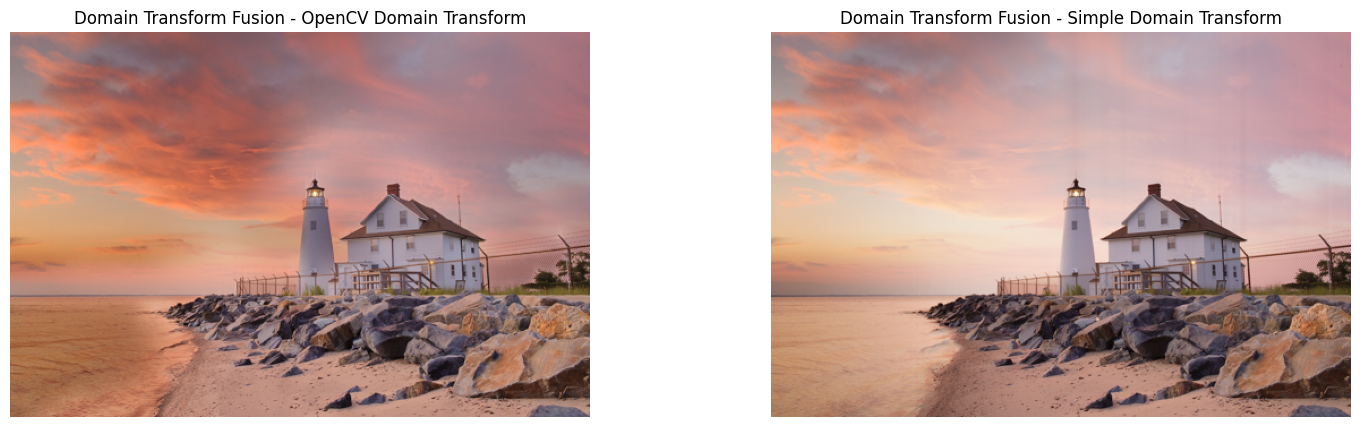

In [16]:
#comparison between homebrew and opencv dt filter
title, fused = methods["Domain Transform"](images, homebrew_dt=False)
title_hb, fused_hb = methods["Domain Transform"](images, homebrew_dt=True)

plt.figure(figsize=(18, 5))
plt.subplot(1, 2, 1)
plt.imshow(fused)
plt.title(title)
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(fused_hb)
plt.title(title_hb)
plt.axis('off')

### Visualization of Methods

#### Visualize wavelet fusion

Visualizes the **wavelet-based fusion** process on a **single color channel**.

##### Features:
- Extracts one color channel (default: Green)
- Displays:
  - The original input channel(s)
  - Horizontal detail coefficients at each decomposition level
  - Final fused image reconstructed from fused coefficients

Fusion is performed by averaging approximation coefficients and applying a max-absolute rule for detail coefficients. Final image is reconstructed via inverse wavelet transform and displayed separately.


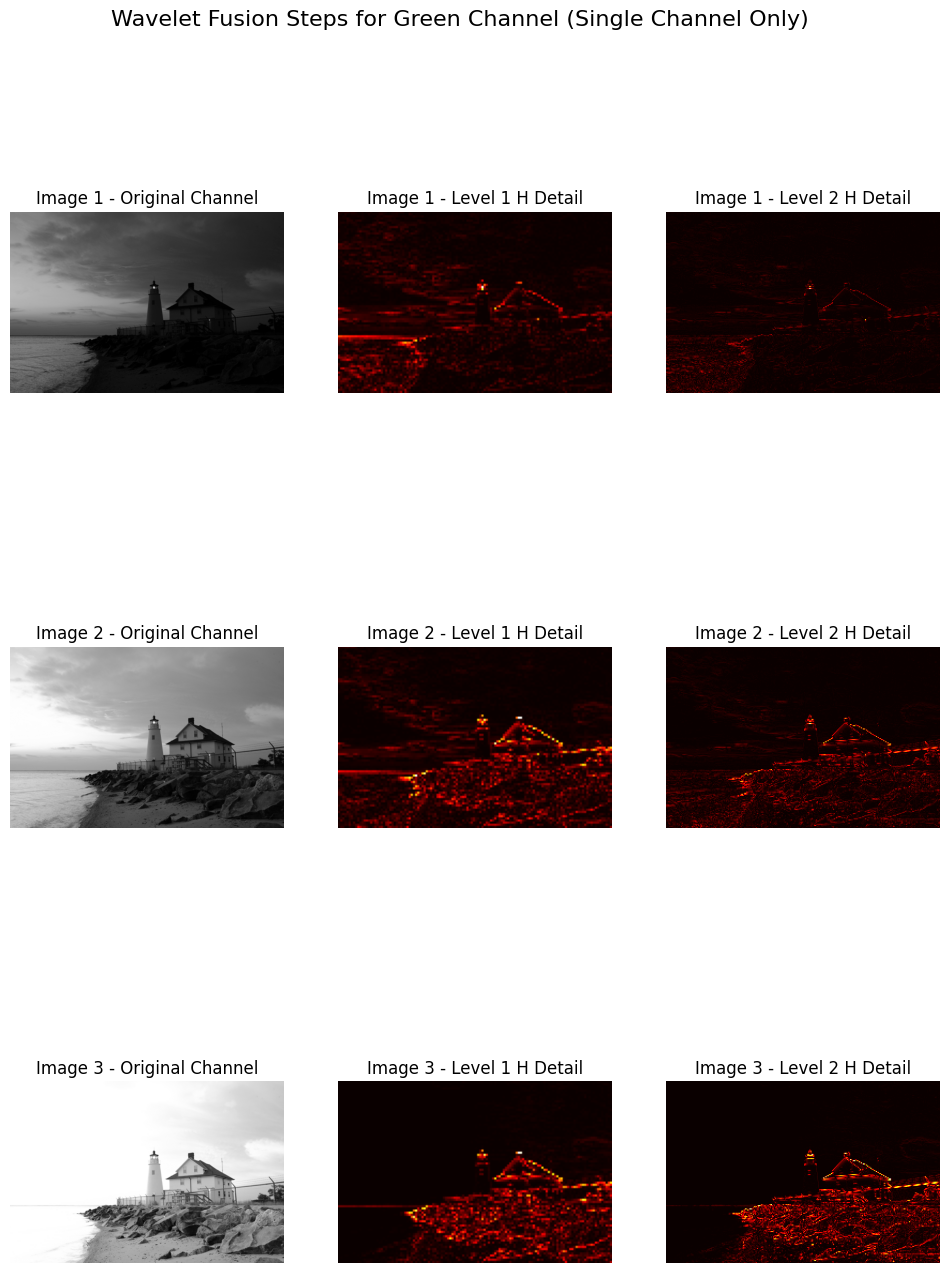

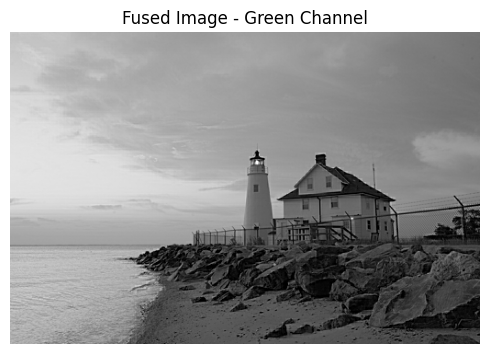

In [17]:
def visualize_wavelet_fusion(images, wavelet='db1', level=2, channel_index=1):
    """
    Visualizes the steps of wavelet fusion for a single color channel.
    Assumes all images are the same size and have 3 color channels (RGB).
    """
    # Extract a single channel (e.g., the green channel) for visualization
    channel_name = ['Blue', 'Green', 'Red'][channel_index]
    imgs = [cv2.split(img)[channel_index].astype(np.float32) / 255.0 for img in images]

    # Compute wavelet coefficients
    coeffs_list = [pywt.wavedec2(img, wavelet=wavelet, level=level) for img in imgs]

    # Set up grid: rows = images, columns = original + detail levels
    fig, axes = plt.subplots(len(imgs), level + 1, figsize=(4 * (level + 1), 4 * len(imgs) + 4))
    if len(imgs) == 1:
        axes = np.expand_dims(axes, 0)

    fig.suptitle(f"Wavelet Fusion Steps for {channel_name} Channel (Single Channel Only)", fontsize=16, y=0.95)

    # Step 1: Show original channel
    for i, img in enumerate(imgs):
        axes[i, 0].imshow(img, cmap='gray')
        axes[i, 0].set_title(f'Image {i+1} - Original Channel')
        axes[i, 0].axis('off')

    # Step 2: Show decomposition details (just horizontal detail)
    for i, coeffs in enumerate(coeffs_list):
        for lvl in range(1, level + 1):
            cH, cV, cD = coeffs[lvl]
            axes[i, lvl].imshow(np.abs(cH), cmap='hot')
            axes[i, lvl].set_title(f'Image {i+1} - Level {lvl} H Detail')
            axes[i, lvl].axis('off')

    # Step 3: Fuse coefficients
    fused_coeffs = []

    # Fuse approximation
    fused_approx = np.mean([coeffs[0] for coeffs in coeffs_list], axis=0)
    fused_coeffs.append(fused_approx)

    # Fuse details
    for lvl in range(1, level + 1):
        fused_details = []
        for i_type in range(3):  # Horizontal, vertical, diagonal
            detail_coeffs = np.array([coeffs[lvl][i_type] for coeffs in coeffs_list])
            fused_detail = np.choose(np.argmax(np.abs(detail_coeffs), axis=0), detail_coeffs)
            fused_details.append(fused_detail)
        fused_coeffs.append(tuple(fused_details))

    # Step 4: Reconstruction
    fused_img = pywt.waverec2(fused_coeffs, wavelet=wavelet)
    h, w = imgs[0].shape
    fused_img = fused_img[:h, :w]
    fused_img = np.clip(fused_img, 0, 1)

    # Step 5: Show fused image in new axis
    fig_fused, ax_fused = plt.subplots(figsize=(5, 5))
    ax_fused.imshow(fused_img, cmap='gray')
    ax_fused.set_title(f'Fused Image - {channel_name} Channel')
    ax_fused.axis('off')

    plt.tight_layout()
    plt.show()

visualize_wavelet_fusion(images, wavelet='db1', level=2, channel_index=1)

#### Visualize laplacian pyramid fusion

This function visualizes the **Laplacian Pyramid Fusion** process step by step. It shows:

- The **Laplacian pyramids** of each input image
- The **fused Laplacian pyramid**
- Optionally, the **Gaussian pyramid** of the first image
- The final **reconstructed fused image**

Each image is first decomposed into a Laplacian pyramid, layers are fused by averaging, and the final image is reconstructed. Visualization is arranged in a grid, with a final display of the full fused result.

##### Helper function: `normalize_for_display`
Used to normalize each image layer to the `[0, 1]` range for visualization. This ensures that even negative or small values from Laplacian layers can be meaningfully displayed.





Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-7.0147053e-09..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.4672784e-08..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-8.609618e-09..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.2665971e-08..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-7.3204e-11..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.3810222e-08..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.6115657e-08..1.0].
Cli

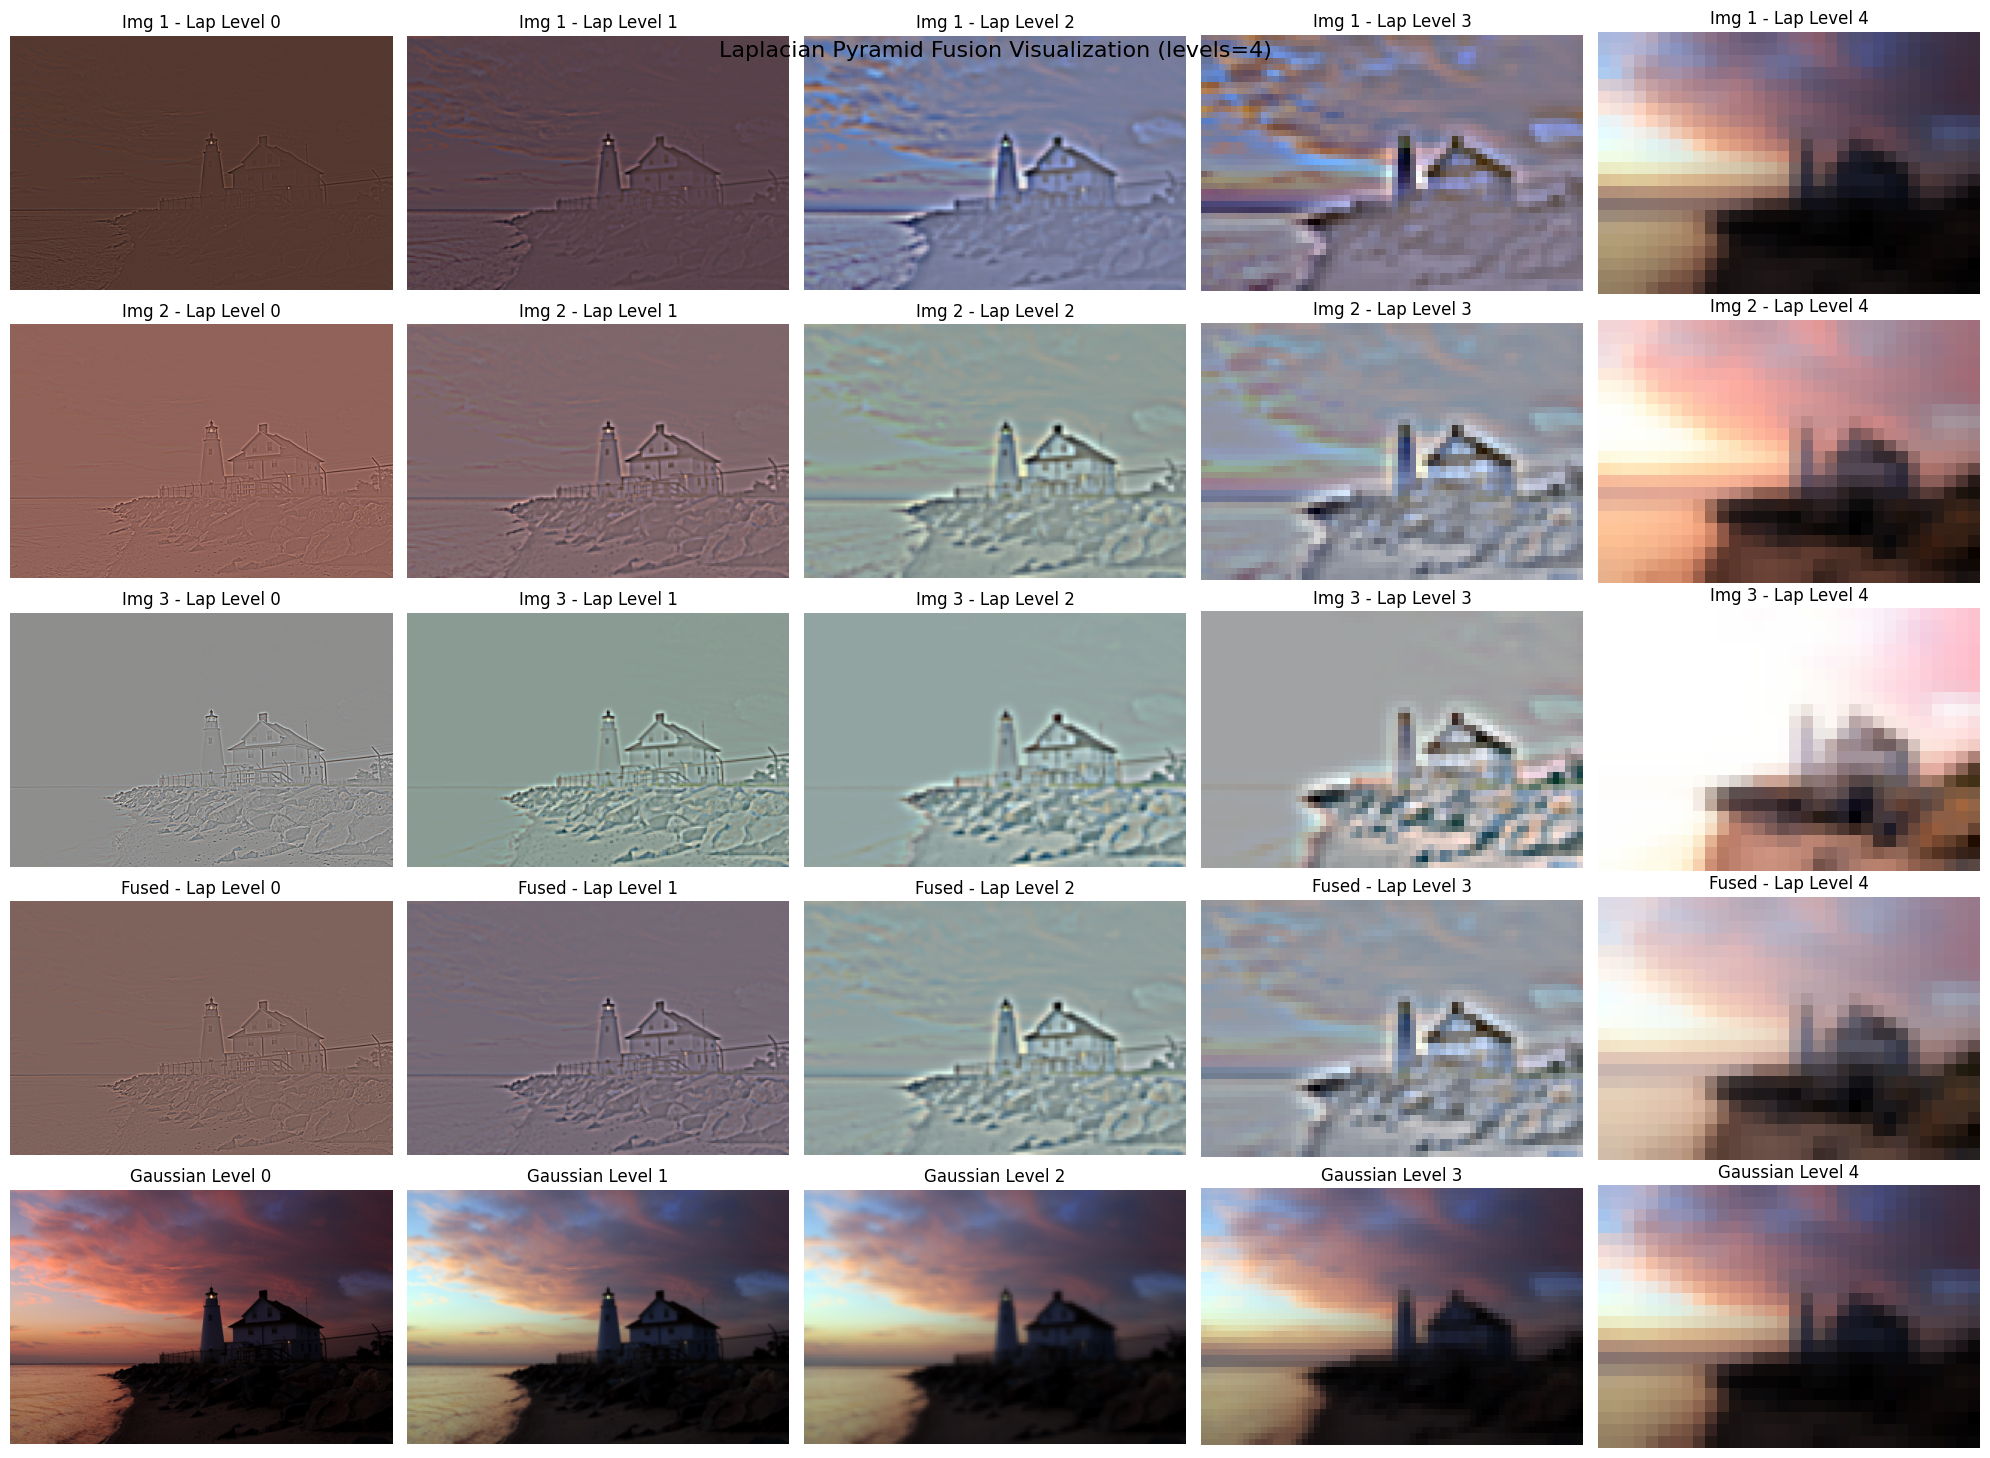

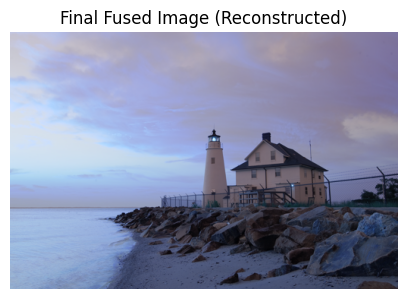

In [ ]:
def normalize_for_display(img):
    """Normalize an image layer to [0, 1] for visualization."""
    img_disp = img.copy()
    if img_disp.ndim == 3:
        for c in range(img_disp.shape[2]):
            ch = img_disp[..., c]
            img_disp[..., c] = cv2.normalize(ch, None, 0, 1, cv2.NORM_MINMAX)
    else:
        img_disp = cv2.normalize(img_disp, None, 0, 1, cv2.NORM_MINMAX)
    return img_disp

def visualize_laplacian_pyramid_fusion(images, levels=4, show_gaussian=True):
    """
    Improved visualization of Laplacian Pyramid Fusion:
    - Shows Gaussian + Laplacian pyramids
    - Normalizes layers for display
    - Displays final fused image
    """
    is_color = images[0].ndim == 3 and images[0].shape[2] == 3
    images = [img.astype(np.float32) for img in images]

    # === Build Gaussian pyramids ===
    gaussian_pyramids = []
    for img in images:
        gp = [img]
        for _ in range(levels):
            img = cv2.pyrDown(img)
            gp.append(img)
        gaussian_pyramids.append(gp)

    # === Build Laplacian pyramids ===
    laplacian_pyramids = []
    for gp in gaussian_pyramids:
        lp = []
        for i in range(len(gp) - 1):
            GE = cv2.pyrUp(gp[i + 1], dstsize=(gp[i].shape[1], gp[i].shape[0]))
            L = gp[i] - GE
            lp.append(L)
        lp.append(gp[-1])  # Lowest level
        laplacian_pyramids.append(lp)

    # === Fuse Laplacian pyramids ===
    fused_pyramid = []
    for level in range(levels + 1):
        stacked = np.array([lp[level] for lp in laplacian_pyramids])
        fused_layer = np.mean(stacked, axis=0)
        fused_pyramid.append(fused_layer)

    # === Reconstruct final fused image ===
    fused = fused_pyramid[-1]
    for i in range(levels, 0, -1):
        fused = cv2.pyrUp(fused, dstsize=(fused_pyramid[i-1].shape[1], fused_pyramid[i-1].shape[0]))
        fused = fused + fused_pyramid[i-1]
    fused = np.clip(fused, 0, 255).astype(np.uint8)

    # === Visualization ===
    rows = len(images)
    pyramid_cols = levels + 1
    total_rows = rows + 1 + (1 if show_gaussian else 0)

    fig, axes = plt.subplots(total_rows, pyramid_cols, figsize=(4 * pyramid_cols, 3 * total_rows))
    fig.suptitle(f"Laplacian Pyramid Fusion Visualization (levels={levels})", fontsize=16, y=0.95)

    # --- Show Laplacian pyramids of input images ---
    for i, lp in enumerate(laplacian_pyramids):
        for l in range(pyramid_cols):
            layer_vis = normalize_for_display(lp[l])
            axes[i, l].imshow(layer_vis)
            axes[i, l].set_title(f"Img {i+1} - Lap Level {l}")
            axes[i, l].axis('off')

    # --- Fused Laplacian pyramid layers ---
    for l in range(pyramid_cols):
        layer_vis = normalize_for_display(fused_pyramid[l])
        axes[rows, l].imshow(layer_vis)
        axes[rows, l].set_title(f"Fused - Lap Level {l}")
        axes[rows, l].axis('off')

    # --- Optional: show Gaussian pyramid of first image ---
    if show_gaussian:
        gp0 = gaussian_pyramids[0]
        for l in range(pyramid_cols):
            g_layer = normalize_for_display(gp0[l])
            axes[rows + 1, l].imshow(g_layer)
            axes[rows + 1, l].set_title(f"Gaussian Level {l}")
            axes[rows + 1, l].axis('off')

    # --- Show final fused image in a separate figure ---
    plt.tight_layout()
    plt.show()

    # Final fused output
    plt.figure(figsize=(5, 5))
    plt.imshow(fused)
    plt.title("Final Fused Image (Reconstructed)")
    plt.axis('off')
    plt.show()

visualize_laplacian_pyramid_fusion(images, levels=4, show_gaussian=True)

### Image Quality Analysis Functions

### 1. Entropy Calculation

Measures the **information content** in an image using Shannon entropy. For each RGB channel:

1. **Histogram Creation**:  
   Counts pixel intensity occurrences across 256 bins (0-255 range).

2. **Probability Distribution**:  
   Converts counts to probabilities:  
   ```math
   p(i) = \frac{\text{count}(i)}{\text{total pixels}}
   ```

3. **Entropy Calculation**:  
   Computes average surprise per pixel:  
   ```math
   H = -\sum_{i=0}^{255} p(i) \cdot \log_2 p(i)
   ```  
   (Zero probabilities are excluded to avoid mathematical errors)

The final result averages entropy values across all three color channels.

---

### 2. Spatial Frequency Calculation
Quantifies **edge activity** through gradient analysis. For each RGB channel:

1. **Horizontal Variation (RF)**:  
   Measures row-wise differences:  
   ```math
   RF = \sqrt{\frac{1}{MN} \sum_{x=1}^{M-1} \sum_{y=0}^{N-1} [I(x,y) - I(x-1,y)]^2}
   ```

2. **Vertical Variation (CF)**:  
   Measures column-wise differences:  
   ```math
   CF = \sqrt{\frac{1}{MN} \sum_{x=0}^{M-1} \sum_{y=1}^{N-1} [I(x,y) - I(x,y-1)]^2}
   ```

3. **Combined Metric**:  
   Merges directions using vector magnitude:  
   ```math
   SF = \sqrt{RF^2 + CF^2}
   ```

The final output averages spatial frequency across all channels.

---

### Key Characteristics Comparison

| Aspect              | Entropy                          | Spatial Frequency               |
|---------------------|----------------------------------|----------------------------------|
| **What it measures** | Randomness in pixel values      | Intensity changes between pixels |
| **High values mean** | Complex textures/variation      | Sharp edges/strong transitions   |
| **Mathematical base**| Information theory              | Gradient energy analysis         |
| **Typical range**   | 0-8 bits (8bpp images)          | 0-50 (image size dependent)      |
| **Usage scenario**  | Assessing texture preservation  | Evaluating edge sharpness        |


In [ ]:
def calculate_entropy(image):
    """Calculates entropy for an RGB image by averaging entropy across channels."""
    entropy_values = []
    for channel in range(image.shape[-1]):  # Loop through R, G, B channels
        hist, _ = np.histogram(image[:, :, channel].ravel(), bins=256, range=(0, 256))
        hist = hist.astype(np.float32) / hist.sum()
        hist = hist[hist > 0]  # Remove zero probabilities
        entropy_values.append(-np.sum(hist * np.log2(hist)))
    return np.mean(entropy_values)  # Average entropy across channels

def spatial_frequency(image):
    """Calculates spatial frequency for an RGB image."""
    sf_values = []
    for channel in range(image.shape[-1]):  # Compute SF for each color channel
        rows, cols = image.shape[:2]
        row_freq = np.sqrt(np.sum(np.diff(image[:, :, channel], axis=0) ** 2) / (rows * cols))
        col_freq = np.sqrt(np.sum(np.diff(image[:, :, channel], axis=1) ** 2) / (rows * cols))
        sf_values.append(np.sqrt(row_freq**2 + col_freq**2))
    return np.mean(sf_values)  # Average SF across channels

## Understanding Similarity Metrics: SSIM and PSNR

### Overview

The function `calculate_metrics_comparison` compares two images using two popular similarity metrics:
- **SSIM (Structural Similarity Index Measure)**
- **PSNR (Peak Signal-to-Noise Ratio)**

These metrics help quantify how similar two images are, which is particularly useful in image processing tasks such as image compression, restoration, and quality assessment.

### 1. SSIM (Structural Similarity Index Measure)

#### Mathematical Explanation

SSIM (Structural Similarity Index) evaluates the perceptual similarity between two images by considering **luminance**, **contrast**, and **structure**. The full SSIM formula is:

$$
\text{SSIM}(x, y) = [l(x, y)]^\alpha \cdot [c(x, y)]^\beta \cdot [s(x, y)]^\gamma
$$

Where:

- $l(x, y) = \frac{2 \mu_x \mu_y + C_1}{\mu_x^2 + \mu_y^2 + C_1}$ is the **luminance** comparison
- $c(x, y) = \frac{2 \sigma_x \sigma_y + C_2}{\sigma_x^2 + \sigma_y^2 + C_2}$ is the **contrast** comparison
- $s(x, y) = \frac{\sigma_{xy} + C_3}{\sigma_x \sigma_y + C_3}$ is the **structure** comparison

Assuming $\alpha = \beta = \gamma = 1$ and $C_3 = \frac{C_2}{2}$, the simplified and most commonly used version is:

$$
\text{SSIM}(x, y) = \frac{(2 \mu_x \mu_y + C_1)(2 \sigma_{xy} + C_2)}{(\mu_x^2 + \mu_y^2 + C_1)(\sigma_x^2 + \sigma_y^2 + C_2)}
$$

Where:

- $\mu_x$, $\mu_y$: mean intensities of images $x$ and $y$
- $\sigma_x^2$, $\sigma_y^2$: variances of $x$ and $y$
- $\sigma_{xy}$: covariance between $x$ and $y$
- $C_1$, $C_2$: small constants to stabilize the division

### 2. PSNR (Peak Signal-to-Noise Ratio)

#### Mathematical Explanation
PSNR measures the quality of a reconstructed image compared to its original version. It is calculated using the Mean Squared Error (MSE) between the images. The formula for PSNR is:

```math
PSNR = 20 \cdot \log_{10}(MAX_I) - 10 \cdot \log_{10}(MSE)
```

where:
- $ MAX_I $ is the maximum possible pixel value (255 for 8-bit images).
- **MSE** is the Mean Squared Error between the two images, defined as:

```math
MSE = \frac{1}{M \times N} \sum_{x,y} \left[ I_1(x, y) - I_2(x, y) \right]^2
```

If the MSE is zero (meaning the images are identical), PSNR is set to infinity.

### Process of the Algorithm

1. **Input Validation and Preprocessing:**
   - **Dimension Check:** The function first verifies whether the two images have the same shape. If not, it resizes the second image to match the dimensions of the first.
   - **Grayscale Conversion:** Both images are converted from RGB to grayscale, as SSIM and PSNR are typically calculated on single-channel images.

2. **SSIM Calculation:**
   - The SSIM metric is computed using the grayscale images to assess the structural similarity between them.

3. **PSNR Calculation:**
   - **MSE Calculation:** The Mean Squared Error between the two grayscale images is computed.
   - **PSNR Formula:** If the MSE is zero, PSNR is set to infinity. Otherwise, PSNR is calculated using the logarithmic formula based on the MSE.

4. **Output:**
   - The function returns two values: the SSIM value (`ssim_value`) and the PSNR value (`psnr_value`).

### Conclusion

- **SSIM** provides a measure of the perceptual similarity between images by taking into account luminance, contrast, and structural differences.
- **PSNR** quantifies the error between images, with higher values indicating better image quality.
- Together, these metrics are essential for comparing image quality and guiding improvements in image processing tasks.


In [ ]:
def calculate_metrics_comparison(img1, img2):
    """Calculate similarity metrics between two images"""
    if(img1 == img2).all():
        return 1, 100
    
    if img1.shape != img2.shape:
        img2 = cv2.resize(img2, (img1.shape[1], img1.shape[0]))
    
    # Convert to grayscale for SSIM/PSNR
    gray1 = cv2.cvtColor(img1, cv2.COLOR_RGB2GRAY)
    gray2 = cv2.cvtColor(img2, cv2.COLOR_RGB2GRAY)
    
    # Calculate SSIM
    ssim_value = ssim(gray1, gray2, data_range=255)
    psnr_value = psnr(gray1, gray2, data_range=255)
    
    return ssim_value, psnr_value

utils_jupyter.compare_methods_and_metrics(spatial_frequency, calculate_entropy, calculate_metrics_comparison, images, methods)

## Comparing Images with Heatmaps and RGB Histograms

This snippet performs the following tasks:

- **Compute Difference:**  
  Calculates the absolute per-pixel difference between two images to highlight changes.

- **Generate Heatmap:**  
  Converts the difference image to grayscale and displays it as a heatmap using a "hot" color map to visualize intensity differences.

- **Display Comparisons:**  
  Uses a utility function to compare multiple images by showing their difference heatmaps alongside their RGB histograms, providing insights into color distribution and changes.

This approach is useful for tasks like image quality assessment and change detection.


In [ ]:
def compute_difference(image1, image2):
    """Compute absolute difference between two images."""
    return cv2.absdiff(image1, image2)

def show_heatmap(diff_image):
    """Display a heatmap of the differences."""
    diff_gray = cv2.cvtColor(diff_image, cv2.COLOR_RGB2GRAY)
    plt.imshow(diff_gray, cmap='hot', interpolation='nearest')
    plt.colorbar()
    plt.title("Difference Heatmap")
    plt.show()

utils_jupyter.compare_methods_display(images, compute_difference, show_heatmap, methods)